In [18]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import datashader as ds
import colorcet as cc
import folium

from collections import defaultdict, OrderedDict
from folium.plugins import HeatMapWithTime
from datetime import datetime
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,10)

In [19]:
#Load the datasets

df_apr14=pd.read_csv("C:data-apr14.csv")
df_may14=pd.read_csv("C:data-may14.csv")
df_jun14=pd.read_csv("Cdata-jun14.csv")
df_jul14=pd.read_csv("C:-data-jul14.csv")
df_aug14=pd.read_csv("C:data-aug14.csv")
df_sep14=pd.read_csv("C:data-sep14.csv")

#Merge the dataframes into one

df = df_apr14.append([df_may14,df_jun14,df_jul14,df_aug14,df_sep14], ignore_index=True)
df.head()


C:\Users\siddhika\AppData\Local\Temp\ipykernel_7132\2561807717.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_apr14.append([df_may14,df_jun14,df_jul14,df_aug14,df_sep14], ignore_index=True)


,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [22]:
# Disaggregate 'Date/Time' column
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

df['Month'] = df['Date/Time'].dt.month
df['Day'] = df['Date/Time'].dt.day
df['Time'] = df['Date/Time'].dt.time

df.head()

,Date/Time,Lat,Lon,Base,Month,Day,Time
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,4,1,00:11:00
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,4,1,00:17:00
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,4,1,00:21:00
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,4,1,00:28:00
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,4,1,00:33:00


In [24]:
# Day of the week
df['Weekday'] = df['Date/Time'].dt.dayofweek

# Hour
df['Hour'] = df['Date/Time'].dt.hour

df.head()

,Date/Time,Lat,Lon,Base,Month,Day,Time,Weekday,Hour
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,4,1,00:11:00,1,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,4,1,00:17:00,1,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,4,1,00:21:00,1,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,4,1,00:28:00,1,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,4,1,00:33:00,1,0


In [25]:
# Map month
month_map = {
    4: 'April',
    5: 'May',
    6: 'June', 
    7: 'July',
    8: 'August',
    9: 'September'
}
df['Month'] = df['Month'].replace(month_map)
# Map weekday
weekday_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday', 
    4: 'Friday', 
    5: 'Saturday',
    6: 'Sunday'
}
df['Weekday'] = df['Weekday'].replace(weekday_map)

final_columns = [
    'Base', 'Lat', 'Lon', 'Month', 
    'Day', 'Weekday', 'Hour']
df = df[final_columns]
df.head()

,Base,Lat,Lon,Month,Day,Weekday,Hour
0,B02512,40.7690,-73.9549,April,1,Tuesday,0
1,B02512,40.7267,-74.0345,April,1,Tuesday,0
2,B02512,40.7316,-73.9873,April,1,Tuesday,0
3,B02512,40.7588,-73.9776,April,1,Tuesday,0
4,B02512,40.7594,-73.9722,April,1,Tuesday,0


In [26]:
num_missing = df.isnull().sum().sum()
print('Number of missing values: {}'.format(num_missing))

Number of missing values: 0


In [27]:
# Latitude must be between -90 and 90
lat_check = df['Lat'].between(-90, 90, inclusive=True).all()
assert lat_check, 'Invalid latitude values exist'

# Longitude must be between -180 and 180
lon_check = df['Lon'].between(-180, 180, inclusive=True).all()
assert lon_check, 'Invalid longitude values exist'

# Hour must be between 0 and 23
hour_check = df['Hour'].between(0, 23, inclusive=True).all()
assert hour_check, 'Invalid hour values exist'

# Day must be between 1 and 31
day_check = df['Day'].between(1, 31, inclusive=True).all()
assert day_check, 'Invalid day values exist'

print('All value ranges valid.')

All value ranges valid.


C:\Users\siddhika\AppData\Local\Temp\ipykernel_7132\614131677.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  lat_check = df['Lat'].between(-90, 90, inclusive=True).all()
C:\Users\siddhika\AppData\Local\Temp\ipykernel_7132\614131677.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  lon_check = df['Lon'].between(-180, 180, inclusive=True).all()
C:\Users\siddhika\AppData\Local\Temp\ipykernel_7132\614131677.py:10: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  hour_check = df['Hour'].between(0, 23, inclusive=True).all()
C:\Users\siddhika\AppData\Local\Temp\ipykernel_7132\614131677.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  day_check = df['Day'].between(1, 31, inclusive=True).all()


In [28]:
# Months must be between 4 and 9
month_check = not set(df['Month']).difference(month_map.values())
assert month_check, 'Invalid Month values'

weekday_check = not set(df['Weekday']).difference(weekday_map.values())
assert weekday_check, 'Invalid Weekday values'

print('Value categories valid.')

Value categories valid.


In [29]:
duplicate_df = df[df.duplicated(keep=False)]
duplicate_df

,Base,Lat,Lon,Month,Day,Weekday,Hour
43,B02512,40.7430,-74.0301,April,1,Tuesday,5
44,B02512,40.7430,-74.0301,April,1,Tuesday,5
127,B02512,40.7805,-73.9481,April,1,Tuesday,7
128,B02512,40.7805,-73.9481,April,1,Tuesday,7
184,B02512,40.7620,-73.9787,April,1,Tuesday,8
...,...,...,...,...,...,...,...
4534256,B02764,40.7714,-73.9502,September,30,Tuesday,22
4534285,B02764,40.7277,-73.9893,September,30,Tuesday,22
4534286,B02764,40.7277,-73.9893,September,30,Tuesday,22
4534290,B02764,40.7212,-74.0048,September,30,Tuesday,22


In [30]:
num_df = df.shape[0]
num_days = len(df[['Month', 'Day']].drop_duplicates())
daily_avg = np.round(num_df/num_days, 0)

stats_raw = 'Number of Pickups: {}\nNumber of Days: {}\nAvg Daily Pickups: {}'
print(stats_raw.format(num_df, num_days, daily_avg))

Number of Pickups: 4534327
Number of Days: 183
Avg Daily Pickups: 24778.0


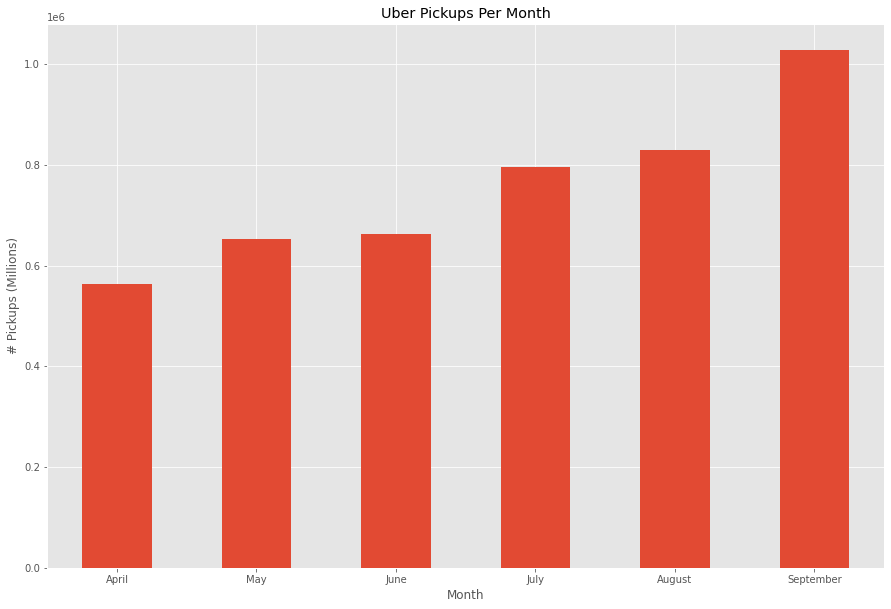

In [31]:
monthly_df = df['Month'].value_counts(ascending=True)[month_map.values()]

monthly_df.plot(kind='bar', rot=0)
plt.title('Uber Pickups Per Month')
plt.xlabel('Month')
plt.ylabel('# Pickups (Millions)');

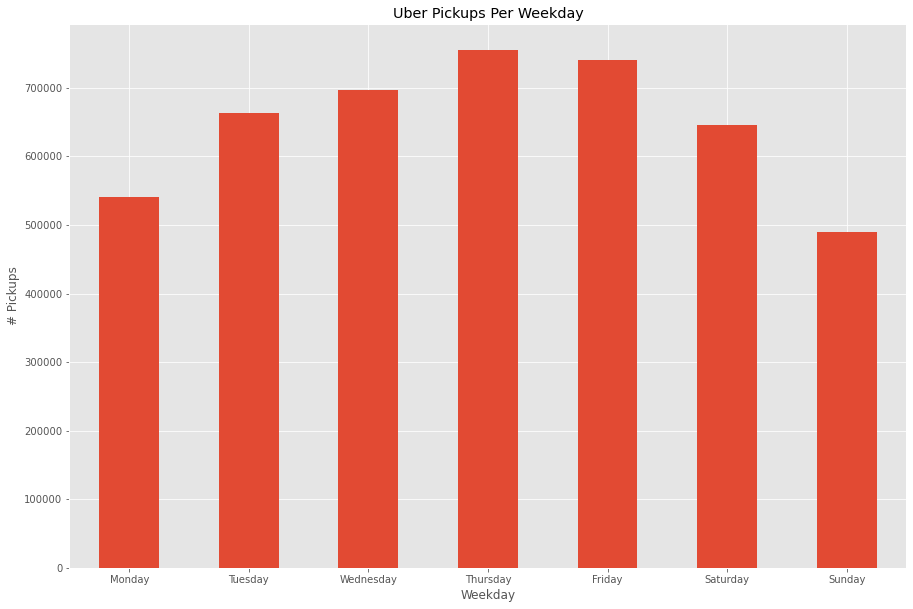

In [32]:
weekday_df = df['Weekday'].value_counts()[weekday_map.values()]

weekday_df.plot(kind='bar', rot=0)
plt.title('Uber Pickups Per Weekday')
plt.xlabel('Weekday')
plt.ylabel('# Pickups');

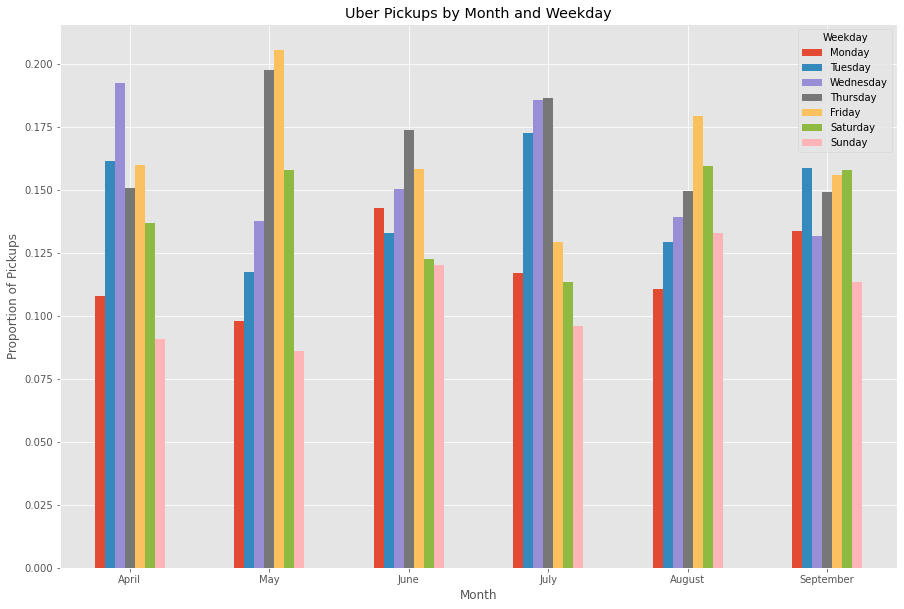

In [33]:
monthly_weekdays = df.groupby('Month')['Weekday'].value_counts().unstack()
monthly_weekdays_norm = monthly_weekdays.apply(lambda x: x/x.sum(), axis=1)

monthly_weekdays_norm.loc[month_map.values(),weekday_map.values()].plot(kind='bar', rot=0)
plt.ylabel('Proportion of Pickups')
plt.title('Uber Pickups by Month and Weekday');


Text(0.5, 1.0, 'Daily Pickups')

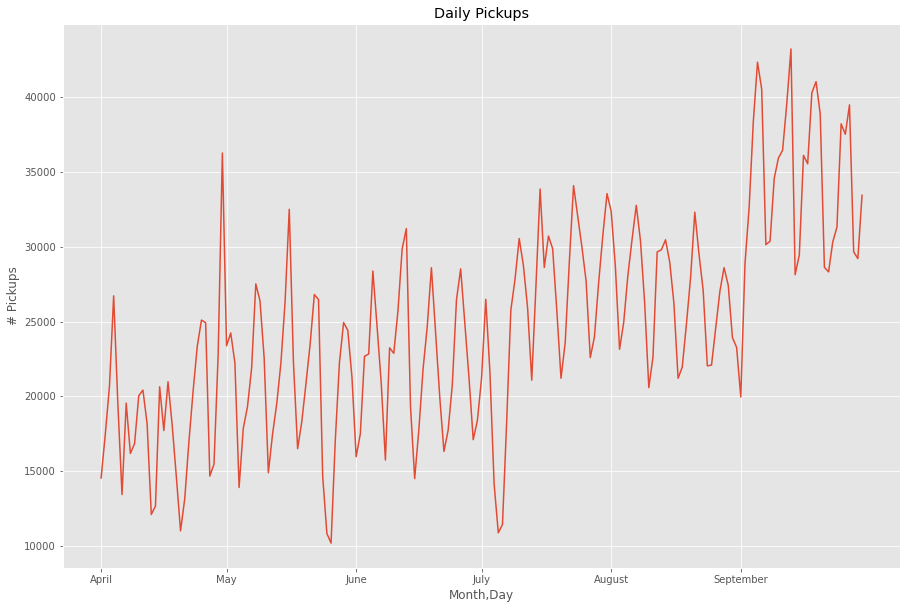

In [34]:
daily_df = df.groupby(['Month', 'Day'])['Hour'].count()[month_map.values()]
daily_df.plot(kind='line', rot=0)
month_starts = np.where(daily_df.reset_index(level=0, drop=True).index.get_loc(1))[0]
plt.xticks(ticks=month_starts, labels=month_map.values())
plt.ylabel('# Pickups')
plt.title('Daily Pickups')

Text(0.5, 1.0, 'Holiday Daily Pickups')

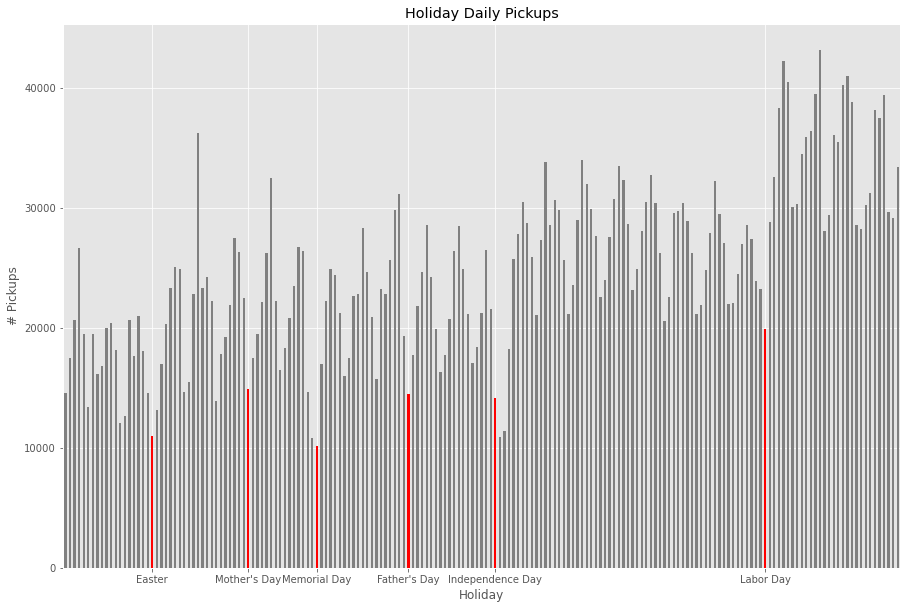

In [37]:
holidays = {
    "Easter": ('April', 20), # Sunday
    "Mother's Day": ('May', 11), # Sunday
    "Memorial Day": ('May', 26), # Monday
    "Father's Day": ('June', 15), # Sunday
    "Independence Day": ('July', 4), # Friday
    "Labor Day": ('September', 1) # Monday
}

holiday_starts = [daily_df.index.get_loc(hol) for hol in holidays.values()]
colors = ['grey' if x not in holiday_starts else 'red' for x in range(len(daily_df))]
daily_df.plot(kind='bar', color=colors, rot=0)
plt.xticks(ticks=holiday_starts, labels=holidays.keys())
plt.xlabel('Holiday')
plt.ylabel('# Pickups')
plt.title('Holiday Daily Pickups')

Text(0.5, 1.0, 'Pickups by Hour of Day')

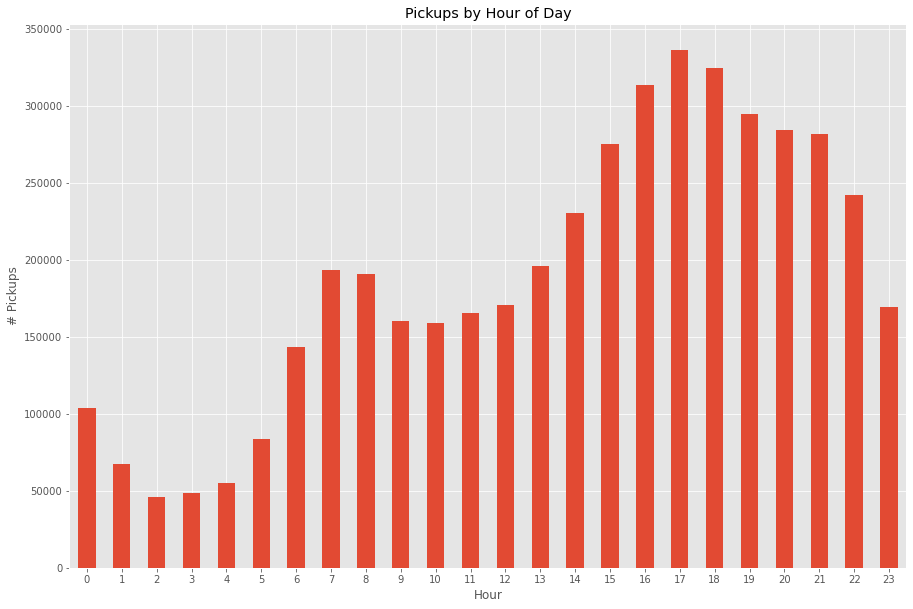

In [38]:
hourly_df = df['Hour'].value_counts().sort_index()

hourly_df.plot(kind='bar', rot=0)
plt.xlabel('Hour')
plt.ylabel('# Pickups')
plt.title('Pickups by Hour of Day')

In [40]:
def plot_subplots(pickups, var_name, var_values, figsize, dim):
    """
    Helper function
    
    Plots subplots for a given variable (Month, Weekday) by Hour
    
    :param pickups: DataFrame containing Uber pickups
    :param var_name: Name of the variable in 'pickups'
    :param var_values: List of variable values
    :param figsize: Tuple contianing figure size
    :param dim: List containing the dimension of subplots
    """
    
    # Figure layout
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    
    # Generate plot
    plot_num = 1
    for value in var_values:
        ax = fig.add_subplot(dim[0], dim[1], plot_num)
        value_df = df[df[var_name] == value]
        plot = (
            value_df['Hour']
            .value_counts(normalize=True)
            .sort_index()
            .plot(kind='bar', ax=ax, rot=0)
        )
        plt.title(value)
        plt.xlabel('Hour')
        plt.ylabel('Proportion of pickups')
        plot_num +=1

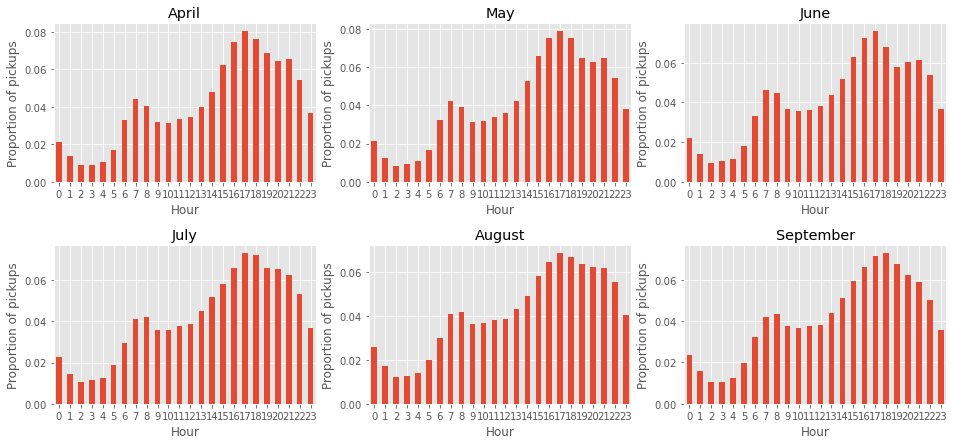

In [41]:
plot_subplots(pickups, 'Month', month_map.values(), (16, 7), [2, 3])

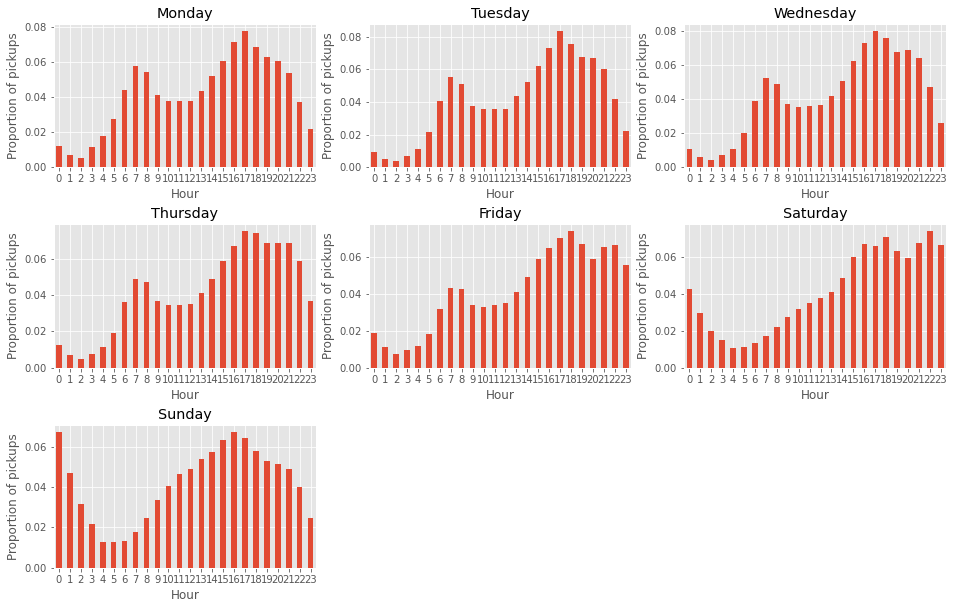

In [42]:
plot_subplots(pickups, 'Weekday', weekday_map.values(), (16, 10), [3, 3])

B02617    0.321735
B02598    0.307237
B02682    0.267468
B02764    0.058200
B02512    0.045359
Name: Base, dtype: float64

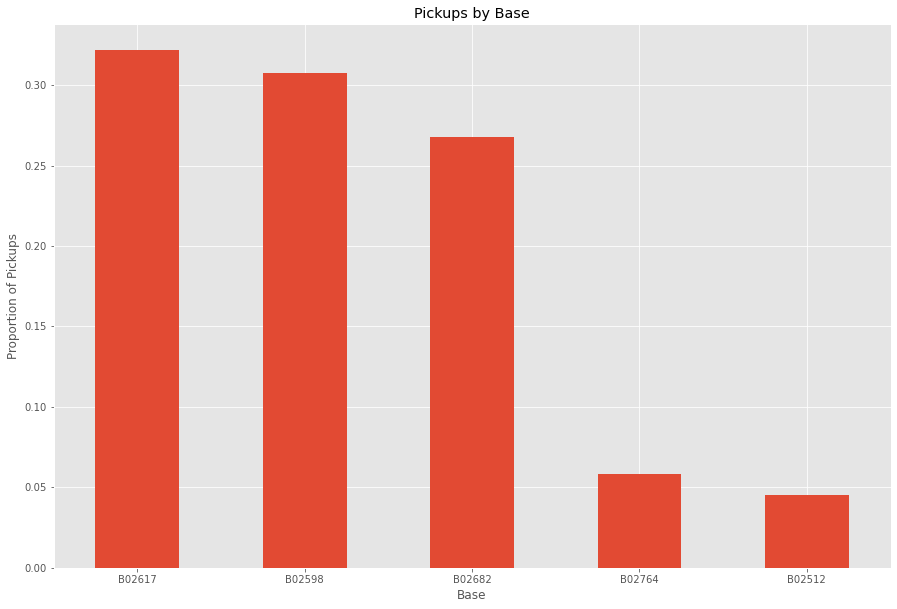

In [44]:
base_props = df['Base'].value_counts(normalize=True)
display(base_props)

base_props.plot(kind='bar', rot=0)
plt.xlabel('Base')
plt.ylabel('Proportion of Pickups')
plt.title('Pickups by Base');

Text(0.5, 1.0, 'Uber Pickups by Month and Base')

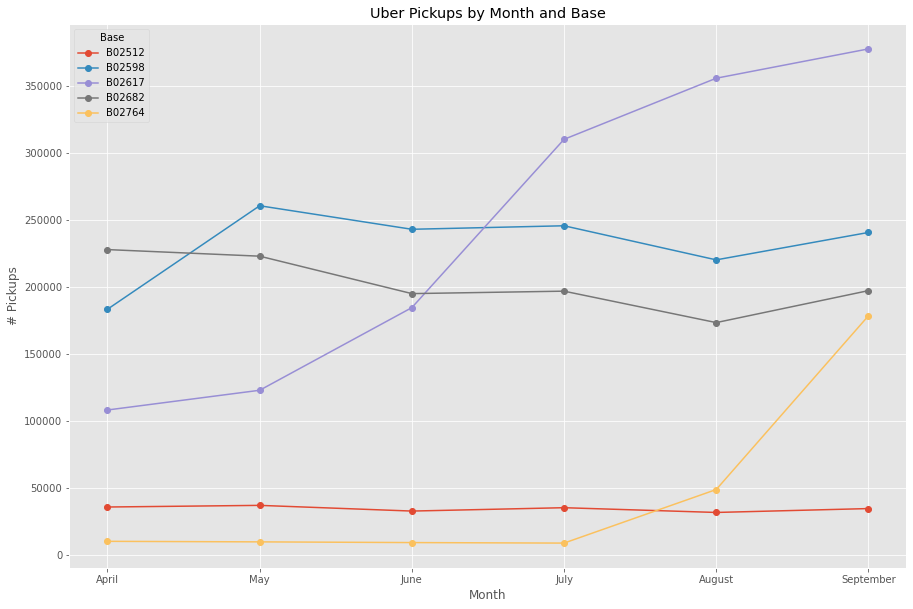

In [45]:
monthly_bases = df.groupby('Month')['Base'].value_counts().unstack()

monthly_bases.loc[month_map.values()].plot(kind='line', marker='o', rot=0)
plt.ylabel('# Pickups')
plt.title('Uber Pickups by Month and Base')

Number of Pickups: 4500872


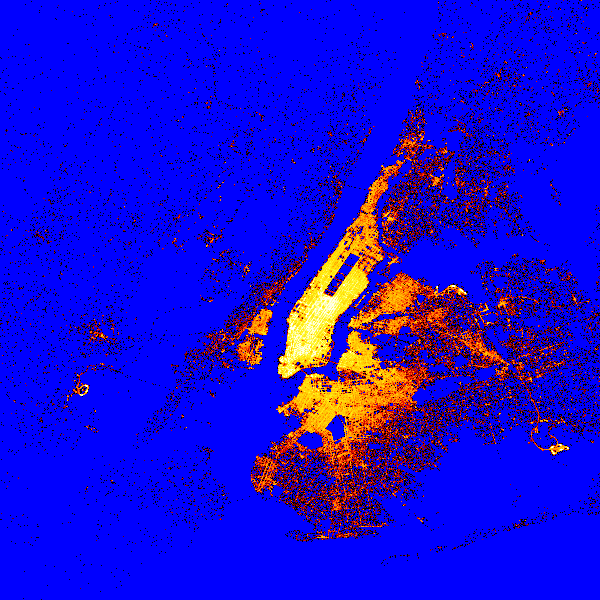

In [48]:
df_focused = df[
    df['Lon'].between(-74.25, -73.75) & 
    df['Lat'].between(40.5, 41)
]
print('Number of Pickups: {}'.format(len(df_focused)))

df_points = ds.Canvas().points(df_focused, 'Lon', 'Lat', )
ds.tf.set_background(ds.tf.shade(df_points, cmap=cc.fire), "blue")

In [49]:
daily_pickup = df.groupby(['Month', 'Day'])['Hour'].count()
print('Busiest Day: {}'.format(daily_df.idxmax()))
print('Number of pickups: {}'.format(daily_df.max()))

Busiest Day: ('September', 13)
Number of pickups: 43205


In [ ]:
#This analysis has provided much insight into the New York City Uber pickups in 2014. Some of the key findings include:
#Heavy increase in pickups during the month of September
#Reductions in pickups during holidays
#Clear difference in the distribution of hourly pickups between workdays and weekends
#Concentration of pickups in Manhattan Island and surrounding areas